In [867]:
import numpy as np  
import math
import pandas as pd 
import matplotlib.pyplot as plt
import os, csv, sys
import glob
import subprocess
from tqdm.notebook import tqdm
from dataclasses import dataclass
from scipy.interpolate import InterpolatedUnivariateSpline
from datetime import datetime, timezone, timedelta
from sklearn.metrics import mean_squared_error 
from decimal import Decimal,getcontext
folder_path = os.path.abspath('gnss_analysis')
sys.path.append(folder_path)
from gnssutils import EphemerisManager,WLS,Troposphere,Ionosphere,ElevationAzimuthAngle

In [868]:
#define constance
LIGHTSPEED = 299_792_458

Data

In [869]:
path = '2023-09-07-19-33-us-ca.csv'
gnss = pd.read_csv(path, index_col=False)
filtered_gnss = gnss[gnss['ReceivedSvTimeNanos'] > 1e10]
selected_col = ['ConstellationType','Svid','utcTimeMillis','ReceivedSvTimeNanos','TimeOffsetNanos','IsrbMeters',
                'RawPseudorangeMeters','Cn0DbHz','MultipathIndicator','RawPseudorangeUncertaintyMeters']
measurement = filtered_gnss[selected_col]
truth = gnss[gnss['ReceivedSvTimeNanos'] > 1e10]


In [870]:
# Lọc các vệ tinh thuộc GPS (ConstellationType == 1)
measurement.loc[measurement['ConstellationType'] == 1, 'Constellation'] = 'G'
truth.loc[truth['ConstellationType'] == 1, 'Constellation'] = 'G'
# Chỉ lấy các vệ tinh bắt GPS
measurement = measurement.loc[measurement['Constellation'] == 'G']
truth = truth.loc[truth['Constellation'] == 'G']
# Đảm bảo cột 'Svid' là chuỗi ký tự để có thể sử dụng hàm str.len()
measurement['Svid'] = measurement['Svid'].astype(str)
truth['Svid'] = truth['Svid'].astype(str)
# Thêm số 0 vào trước 'Svid' nếu chiều dài của nó là 1
measurement.loc[measurement['Svid'].str.len() == 1, 'Svid'] = '0' + measurement['Svid']
truth.loc[truth['Svid'].str.len() == 1, 'Svid'] = '0' + truth['Svid']
# Tạo cột mới 'SvName' bằng cách nối 'Constellation' và 'Svid'
measurement['SvName'] = measurement['Constellation'] + measurement['Svid']
truth['SvName'] = truth['Constellation'] + truth['Svid']



C:\Users\ductm\AppData\Local\Temp\ipykernel_18868\1394250255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurement.loc[measurement['ConstellationType'] == 1, 'Constellation'] = 'G'


In [871]:
#chuyển giá trị thời gian về dạng date time
measurement['UnixTime'] = pd.to_datetime(measurement['utcTimeMillis'],unit='ms', utc=True)
#Chia measurement thành các epoch, mỗi epoch gồm các vệ tinh có cùng thời gian thu
measurement['Epoch'] = 0
measurement.loc[measurement['UnixTime'] - measurement['UnixTime'].shift() > timedelta(milliseconds=200), 'Epoch'] = 1
measurement['Epoch'] = measurement['Epoch'].cumsum()

In [872]:
#chuyển giá trị thời gian về dạng date time
truth['UnixTime'] = pd.to_datetime(truth['utcTimeMillis'],unit='ms', utc=True)
#Chia measurement thành các epoch, mỗi epoch gồm các vệ tinh có cùng thời gian thu
truth['Epoch'] = 0
truth.loc[truth['UnixTime'] - truth['UnixTime'].shift() > timedelta(milliseconds=200), 'Epoch'] = 1
truth['Epoch'] = truth['Epoch'].cumsum()

In [873]:
# Khởi tạo biến để lưu trữ kết quả
filtered_measurement = pd.DataFrame()

# Duyệt qua từng epoch
for epoch in measurement['Epoch'].unique():
    one_epoch = measurement.loc[measurement['Epoch'] == epoch].drop_duplicates(subset='SvName')
    # Thêm kết quả vào DataFrame kết quả
    filtered_measurement = pd.concat([filtered_measurement, one_epoch])

# Reset index của DataFrame mới
filtered_measurement.reset_index(drop=True, inplace=True)
filtered_measurement = filtered_measurement.groupby('Epoch').apply(lambda x: x.sort_values(by='Svid')).reset_index(drop=True)
measurement = filtered_measurement

C:\Users\ductm\AppData\Local\Temp\ipykernel_18868\3100079312.py:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  filtered_measurement = filtered_measurement.groupby('Epoch').apply(lambda x: x.sort_values(by='Svid')).reset_index(drop=True)


In [874]:
# Khởi tạo biến để lưu trữ kết quả
filtered_measurement1 = pd.DataFrame()

# Duyệt qua từng epoch
for epoch in truth['Epoch'].unique():
    one_epoch = truth.loc[truth['Epoch'] == epoch].drop_duplicates(subset='SvName')
    # Thêm kết quả vào DataFrame kết quả
    filtered_measurement1 = pd.concat([filtered_measurement1, one_epoch])

# Reset index của DataFrame mới
filtered_measurement1.reset_index(drop=True, inplace=True)
filtered_measurement1 = filtered_measurement1.groupby('Epoch').apply(lambda x: x.sort_values(by='Svid')).reset_index(drop=True)
truth = filtered_measurement1


C:\Users\ductm\AppData\Local\Temp\ipykernel_18868\889482863.py:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  filtered_measurement1 = filtered_measurement1.groupby('Epoch').apply(lambda x: x.sort_values(by='Svid')).reset_index(drop=True)


In [875]:
#lấy dữ liệu ephemeris
ephemeris_data_directory = 'output'
manager = EphemerisManager(ephemeris_data_directory)

measurement['UnixTime'] = pd.to_datetime(measurement['utcTimeMillis'],unit='ms', utc=True)
timestamps = pd.to_datetime(measurement['UnixTime'].unique(),unit='s')
ephemeris_data = pd.DataFrame()

for timestamp in timestamps:
    # Get satellite names for the current timestamp
    sats = measurement.loc[measurement['UnixTime'] == timestamp, 'SvName'].tolist()
    # Retrieve ephemeris data
    ephemeris = manager.get_ephemeris(timestamp, sats)
    
    # Append the retrieved ephemeris data to the list
    ephemeris_data = pd.concat([ephemeris_data,ephemeris])
    

ephemeris_data.reset_index(drop=True, inplace=True)
# ephemeris_data.to_csv("ephe1.csv")

Tính toán svPosition và svVelocity của GPS

In [876]:
def calculate_satellite_position_in_GPS(ephemeris, transmit_time):
    mu = 3.986005e14
    OmegaDot_e = 7.2921151467e-5
    # F = -4.442807633e-10
    sv_position = pd.DataFrame()
    sv_position['sv']= ephemeris.index
    sv_position.set_index('sv', inplace=True)
    sv_position['t_k'] = transmit_time - ephemeris['t_oe']
    A = ephemeris['sqrtA'].pow(2)
    n_0 = np.sqrt(mu / A.pow(3))
    n = n_0 + ephemeris['deltaN']
    M_k = ephemeris['M_0'] + n * sv_position['t_k']
    E_k = M_k
    err = pd.Series(data=[1]*len(sv_position.index))
    i = 0
    
    # Eccentric anomaly
    while err.abs().min() > 1e-8 and i < 10:
        new_vals = E_k + (M_k - E_k + ephemeris['e']*np.sin(E_k))/(1 - ephemeris['e'] * np.cos(E_k))
        err = new_vals - E_k
        E_k = new_vals
        i += 1
        
    # delT_r = F * ephemeris['e'].pow(ephemeris['sqrtA']) * sinE_k
    # delT_oc = transmit_time - ephemeris['t_oc']
    # sv_position['delT_sv'] = ephemeris['SVclockBias'] + ephemeris['SVclockDrift'] * delT_oc + ephemeris['SVclockDriftRate'] * delT_oc.pow(2)

    v_k = 2 * np.arctan(np.sqrt((1 + ephemeris['e'])/(1 - ephemeris['e'])) * np.tan(E_k/2))

    Phi_k = v_k + ephemeris['omega']

    sin2Phi_k = np.sin(2*Phi_k)
    cos2Phi_k = np.cos(2*Phi_k)

    du_k = ephemeris['C_us']*sin2Phi_k + ephemeris['C_uc']*cos2Phi_k
    dr_k = ephemeris['C_rs']*sin2Phi_k + ephemeris['C_rc']*cos2Phi_k
    di_k = ephemeris['C_is']*sin2Phi_k + ephemeris['C_ic']*cos2Phi_k

    u_k = Phi_k + du_k

    r_k = A*(1 - ephemeris['e']*np.cos(E_k)) + dr_k

    i_k = ephemeris['i_0'] + di_k + ephemeris['IDOT']*sv_position['t_k']

    x_k_prime = r_k*np.cos(u_k)
    y_k_prime = r_k*np.sin(u_k)

    Omega_k = ephemeris['Omega_0'] + (ephemeris['OmegaDot'] - OmegaDot_e)*sv_position['t_k'] - OmegaDot_e*ephemeris['t_oe']

    sv_position['x_k'] = x_k_prime*np.cos(Omega_k) - y_k_prime*np.cos(i_k)*np.sin(Omega_k)
    sv_position['y_k'] = x_k_prime*np.sin(Omega_k) + y_k_prime*np.cos(i_k)*np.cos(Omega_k)
    sv_position['z_k'] = y_k_prime*np.sin(i_k)
    sv_position['SvClockBiasMeters'] = ephemeris['SVclockBias'] * LIGHTSPEED
    sv_position['SvClockDriftMetersPerSecond'] = ephemeris['SVclockDrift'] * LIGHTSPEED
    
    #calculate velocuty
    Edot_k = n_0/(1-ephemeris['e']*np.cos(E_k))
    
    vdot_k = Edot_k * np.sqrt(1 - ephemeris['e']**2)/(1 - ephemeris['e']*np.cos(E_k))
    
    d_idotk = ephemeris['IDOT'] + 2 * vdot_k * (ephemeris['C_is'] * cos2Phi_k - ephemeris['C_ic']*sin2Phi_k)
    
    udot_k = vdot_k + 2 * vdot_k * (ephemeris['C_us']*cos2Phi_k - ephemeris['C_uc']*sin2Phi_k)
    
    rdot_k = ephemeris['e'] * A * Edot_k * np.sin(E_k) + 2 * vdot_k * (ephemeris['C_rs'] * cos2Phi_k - ephemeris['C_rc'] * sin2Phi_k)
    
    Omegadot_k = ephemeris['OmegaDot'] - OmegaDot_e
    
    x_plus_dot_k = rdot_k * np.cos(u_k) - r_k * udot_k*np.sin(u_k)
    y_plus_dot_k = rdot_k * np.sin(u_k) + r_k * udot_k*np.cos(u_k)
    
    sv_position['v_x'] = -x_k_prime * Omegadot_k * np.sin(Omega_k) + x_plus_dot_k * np.cos(Omega_k) - y_plus_dot_k * np.sin(Omega_k)*np.cos(i_k) - y_k_prime * (Omegadot_k * np.cos(Omega_k) * np.cos(i_k) - d_idotk * np.sin(Omega_k)*np.sin(i_k))
    
    sv_position['v_y'] = x_k_prime * Omegadot_k * np.cos(Omega_k) + x_plus_dot_k * np.sin(Omega_k) + y_plus_dot_k * np.cos(Omega_k)*np.cos(i_k) - y_k_prime * (Omegadot_k * np.sin(Omega_k) * np.cos(i_k) + d_idotk * np.cos(Omega_k)*np.sin(i_k))
    
    sv_position['v_z'] = y_plus_dot_k * np.sin(i_k) + y_k_prime * d_idotk * np.cos(i_k)
    
    
    return sv_position

Tính toán svPosition và svVelocity của GLONASS

In [877]:
# Run the function and check out the results:
measurement['ReceivedSvTimeNanos'] = pd.to_numeric(measurement['ReceivedSvTimeNanos'])
measurement['TimeOffsetNanos'] = pd.to_numeric(measurement['TimeOffsetNanos'])
sv_position = calculate_satellite_position_in_GPS(ephemeris_data,  1e-9*(measurement['ReceivedSvTimeNanos'] + measurement['TimeOffsetNanos']))
measurement['tTxSeconds'] = 1e-9*(measurement['ReceivedSvTimeNanos'] + measurement['TimeOffsetNanos'])
measurement['SvPositionXEcefMeters'] = sv_position['x_k']
measurement['SvPositionYEcefMeters'] = sv_position['y_k']
measurement['SvPositionZEcefMeters'] = sv_position['z_k']
measurement['SvVelocityXEcefMetersPerSecond'] = sv_position['v_x']
measurement['SvVelocityYEcefMetersPerSecond'] = sv_position['v_y']
measurement['SvVelocityZEcefMetersPerSecond'] = sv_position['v_z']
measurement['SvClockBiasMeters'] = sv_position['SvClockBiasMeters']
measurement['SvClockDriftMetersPerSecond'] = sv_position['SvClockDriftMetersPerSecond']


measurement = measurement.loc[measurement['IsrbMeters'] == 0.0]
measurement.reset_index(drop=True, inplace=True)
truth = truth.loc[truth['IsrbMeters'] == 0.0]
truth.reset_index(drop=True, inplace=True)
# truth['TroposphericDelayMeters'].to_csv('truth.csv')
# sv_position.to_csv('sv_position.csv')






0.06862444226940162


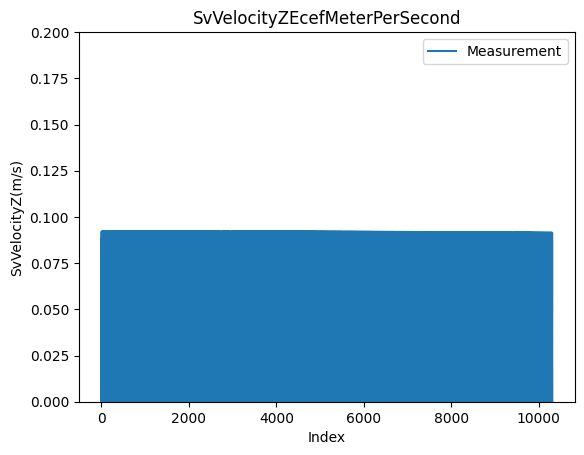

In [892]:
# measurement[['SvPositionXEcefMeters','SvPositionYEcefMeters','SvPositionZEcefMeters','tTxSeconds']].head(20)
# measurement[['ReceivedSvTimeNanos']]
mea = pd.DataFrame()
t = pd.DataFrame()
Z = 'Z'
mea['SvVelocity' + Z + 'EcefMetersPerSecond1'] = measurement['SvVelocity' + Z + 'EcefMetersPerSecond']

t['SvVelocity' + Z + 'EcefMetersPerSecond'] = truth['SvVelocity' + Z + 'EcefMetersPerSecond']
# t['SvPosition' + Z + 'EcefMeters'].to_csv('distance.csv')

merged_df = pd.merge(mea, t,left_index=True, right_index=True)
merged_df = merged_df.dropna()

merged_df['dif'] = measurement['SvVelocity' + Z + 'EcefMetersPerSecond'] - truth['SvVelocity' + Z + 'EcefMetersPerSecond']

RMSE = np.sqrt(np.square(np.subtract(mea['SvVelocity' + Z + 'EcefMetersPerSecond1'] , t['SvVelocity' + Z + 'EcefMetersPerSecond'])).mean())
print(RMSE)

# _measurement = mea['SvVelocity' + Z + 'EcefMetersPerSecond1'].tolist()[:100]
# _trust = t['SvVelocity' + Z + 'EcefMetersPerSecond'].tolist()[:100]

plt.plot(merged_df['dif'].tolist(),label = 'Measurement')
# plt.plot(_trust,label = 'Google')
plt.xlabel('Index')
plt.ylabel('SvVelocity' + Z +'(m/s)')
plt.title('SvVelocity' + Z +'EcefMeterPerSecond')
plt.ylim([0,0.2])
plt.legend()
plt.show()

0.7284415004424026


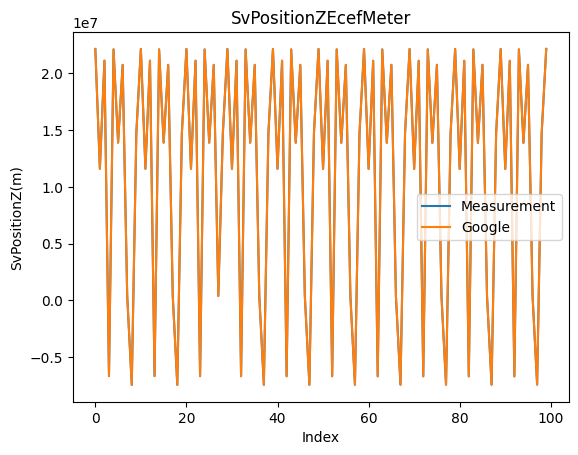

In [889]:
# measurement[['SvPositionXEcefMeters','SvPositionYEcefMeters','SvPositionZEcefMeters','tTxSeconds']].head(20)
# measurement[['ReceivedSvTimeNanos']]
mea = pd.DataFrame()
t = pd.DataFrame()
Z = 'Z'
mea['SvPosition' + Z + 'EcefMeters1'] = measurement['SvPosition' + Z + 'EcefMeters']

t['SvPosition' + Z + 'EcefMeters'] = truth['SvPosition' + Z + 'EcefMeters']
# t['SvPosition' + Z + 'EcefMeters'].to_csv('distance.csv')

merged_df = pd.merge(mea, t,left_index=True, right_index=True)
merged_df = merged_df.dropna()

merged_df['dif'] = measurement['SvPosition' + Z + 'EcefMeters'] - truth['SvPosition' + Z + 'EcefMeters']

RMSE = np.sqrt(np.square(np.subtract(mea['SvPosition' + Z + 'EcefMeters1'] , t['SvPosition' + Z + 'EcefMeters'])).mean())
print(RMSE)

_measurement = mea['SvPosition' + Z + 'EcefMeters1'].tolist()[:100]
_trust = t['SvPosition' + Z + 'EcefMeters'].tolist()[:100]

plt.plot(_measurement,label = 'Measurement')
plt.plot(_trust,label = 'Google')
plt.xlabel('Index')
plt.ylabel('SvPosition' + Z +'(m)')
plt.title('SvPosition' + Z +'EcefMeter')

plt.legend()
plt.show()

In [880]:
def my_ecef2lla(pos):
  # x, y and z are scalars or vectors in meters
  X = pos[0]
  Y = pos[1]
  Z = pos[2]
  # WGS84 constants
  a = 6378137.0  # Semi-major axis
  f = 1 / 298.257223563  # Flattening
  e2 = 2 * f - f * f  # Square of eccentricity
  
  # Calculations
  r = math.sqrt(X**2 + Y**2)
  E2 = a**2 - (a * (1 - f))**2
  F = 54 * (a * (1 - f))**2 * Z**2
  G = r**2 + (1 - e2) * Z**2 - e2 * E2
  c = (e2**2 * F * r**2) / (G**3)
  s = (1 + c + math.sqrt(c**2 + 2 * c))**(1/3)
  P = F / (3 * (s + 1/s + 1)**2 * G**2)
  Q = math.sqrt(1 + 2 * e2**2 * P)
  r0 = -(P * e2 * r) / (1 + Q) + math.sqrt(0.5 * a**2 * (1 + 1/Q) - (P * (1 - e2) * Z**2) / (Q * (1 + Q)) - 0.5 * P * r**2)
  U = math.sqrt((r - e2 * r0)**2 + Z**2)
  V = math.sqrt((r - e2 * r0)**2 + (1 - e2) * Z**2)
  Z0 = (a * (1 - f))**2 * Z / (a * V)
  h = U * (1 - (a * (1 - f))**2 / (a * V))
  phi = math.atan((Z + e2 * Z0) / r)
  lambda_ = math.atan2(Y, X)
  
  # Convert radians to degrees
  latitude = math.degrees(phi)
  longitude = math.degrees(lambda_)
  
  return latitude, longitude, h


Tính toàn evelation và azimuth

In [881]:
# Đường dẫn đến file RINEX navigation của bạn
get_alpha_beta = manager.get_filepaths(timestamp)
path = get_alpha_beta['nasa_daily_gps']['filepath']
file_with_extension = os.path.basename(path)
file_name, extension = os.path.splitext(file_with_extension)
file_name = "output/nasa/" + file_name
alpha, beta = manager.extract_ionospheric_params(file_name)


In [882]:

wls = WLS()
angle = ElevationAzimuthAngle()
calculate_tropo = Troposphere()
calculate_iono = Ionosphere()
ecef_list = []
for epoch in measurement['Epoch'].unique():
    # measurement['IsrbMeters'].loc[len(measurement['IsrbMeters'])] = 0
    one_epoch = measurement.loc[(measurement['Epoch'] == epoch)] 
    if len(one_epoch.index) > 4:
        x = wls.WLS_onePosition_rawPseudo(one_epoch)
        estimated_lla = my_ecef2lla(x)
        for index in one_epoch.index:
            result_list = measurement.loc[index, ['SvPositionXEcefMeters', 'SvPositionYEcefMeters', 'SvPositionZEcefMeters']]
            satellite_ecef = (result_list)
            elevation, azimuth = angle.CalculateAngle(satellite_ecef,estimated_lla)

            # Thêm các giá trị mới vào DataFrame
            measurement.at[index , 'SvElevationDegrees'] = elevation
            measurement.at[index , 'SvAzimuthDegrees'] = azimuth


C:\Users\ductm\AppData\Local\Temp\ipykernel_18868\1753034491.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurement.at[index , 'SvElevationDegrees'] = elevation
C:\Users\ductm\AppData\Local\Temp\ipykernel_18868\1753034491.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurement.at[index , 'SvAzimuthDegrees'] = azimuth


Sai số của 2 góc

0.0008567075623220458


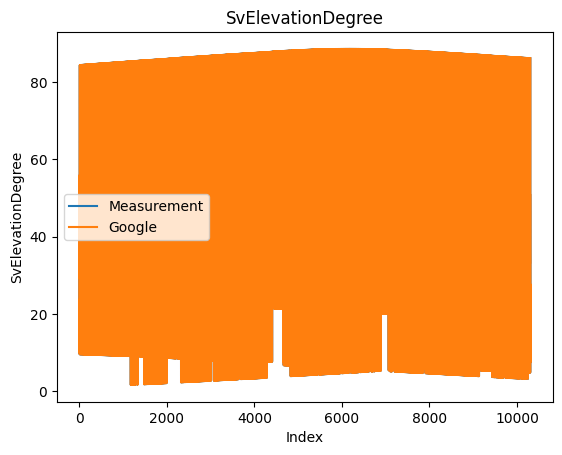

In [883]:
mea = pd.DataFrame()
t = pd.DataFrame()
mea['SvElevationDegrees1'] = measurement['SvElevationDegrees']

t['SvElevationDegrees'] = truth['SvElevationDegrees']


merged_df = pd.merge(mea, t,left_index=True, right_index=True)
merged_df = merged_df.dropna()
RMSE = np.sqrt(np.square(np.subtract(mea['SvElevationDegrees1'] , t['SvElevationDegrees'])).mean())
print(RMSE)
_measurement = mea['SvElevationDegrees1'].tolist()
_trust = t['SvElevationDegrees'].tolist()
plt.plot(_measurement,label = 'Measurement')
plt.plot(_trust,label = 'Google')
plt.xlabel('Index')
plt.ylabel('SvElevationDegree')
plt.title('SvElevationDegree')

plt.legend()
plt.show()


0.008707636278131748


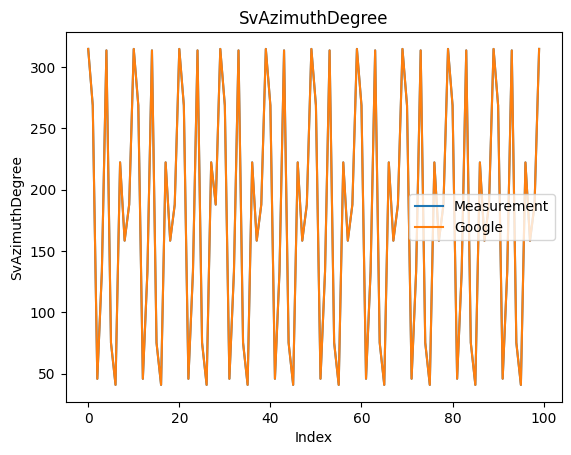

In [884]:
mea = pd.DataFrame()
t = pd.DataFrame()
mea['SvAzimuthDegrees1'] = measurement['SvAzimuthDegrees']

t['SvAzimuthDegrees'] = truth['SvAzimuthDegrees']
mea['SvAzimuthDegrees1'].to_csv('truth.csv')


merged_df = pd.merge(mea, t,left_index=True, right_index=True)
merged_df = merged_df.dropna()
RMSE = np.sqrt(np.square(np.subtract(mea['SvAzimuthDegrees1'] , t['SvAzimuthDegrees'])).mean())
print(RMSE)
_measurement = mea['SvAzimuthDegrees1'].tolist()[:100]
_trust = t['SvAzimuthDegrees'].tolist()[:100]
plt.plot(_measurement,label = 'Measurement')
plt.plot(_trust,label = 'Google')
plt.xlabel('Index')
plt.ylabel('SvAzimuthDegree')
plt.title('SvAzimuthDegree')

plt.legend()
plt.show()

tính toán trễ Iono và Tropo

In [885]:
for epoch in measurement['Epoch'].unique():
    one_epoch = measurement.loc[(measurement['Epoch'] == epoch)] 
    if len(one_epoch.index) > 4:
        x = wls.WLS_onePosition_rawPseudo(one_epoch)
        estimated_lla = my_ecef2lla(x)
        for index in one_epoch.index:
            result_list = measurement.loc[index, ['SvPositionXEcefMeters', 'SvPositionYEcefMeters', 'SvPositionZEcefMeters']]
            satellite_ecef = (result_list)
            measurement.at[index,'TroposphericDelayMeters'] = calculate_tropo.calculateTropoCorrectionMeters(
                np.deg2rad(measurement['SvElevationDegrees'].iloc[index]),
                np.deg2rad(estimated_lla[0]),
                estimated_lla[2],
                measurement['utcTimeMillis'].iloc[index])

            measurement.at[index,'IonosphericDelayMeters'] = calculate_iono.klobuchar_ionospheric_delay(
                measurement['utcTimeMillis'].iloc[index],
                estimated_lla[0],
                estimated_lla[1],
                measurement['SvAzimuthDegrees'].iloc[index],
                measurement['SvElevationDegrees'].iloc[index],
                alpha,
                beta)
        

C:\Users\ductm\AppData\Local\Temp\ipykernel_18868\74277611.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurement.at[index,'TroposphericDelayMeters'] = calculate_tropo.calculateTropoCorrectionMeters(
C:\Users\ductm\AppData\Local\Temp\ipykernel_18868\74277611.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurement.at[index,'IonosphericDelayMeters'] = calculate_iono.klobuchar_ionospheric_delay(


2.9038335294542685


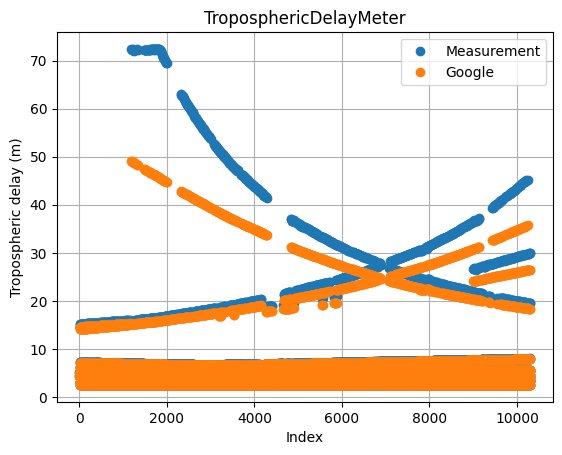

In [886]:
mea = pd.DataFrame()
t = pd.DataFrame()
mea['TroposphericDelayMeters1'] = measurement['TroposphericDelayMeters']

t['TroposphericDelayMeters'] = truth['TroposphericDelayMeters']
# mea['TroposphericDelayMeters1'].to_csv('truth1.csv')


merged_df = pd.merge(mea, t,left_index=True, right_index=True)
merged_df = merged_df.dropna()
merged_df['dif'] = abs(mea['TroposphericDelayMeters1'] - t['TroposphericDelayMeters'])
RMSE = np.sqrt(np.square(np.subtract(mea['TroposphericDelayMeters1'] , t['TroposphericDelayMeters'])).mean())
print(RMSE)
_measurement = mea['TroposphericDelayMeters1'].tolist()
_trust = t['TroposphericDelayMeters'].tolist()


plt.plot(_measurement, label='Measurement',marker='o', linestyle='none')
plt.plot(_trust,label = 'Google',marker='o', linestyle='none')
plt.title('TroposphericDelayMeter')

plt.legend()
plt.xlabel('Index')
plt.ylabel('Tropospheric delay (m)')
plt.grid(True)



6.9275826994449385


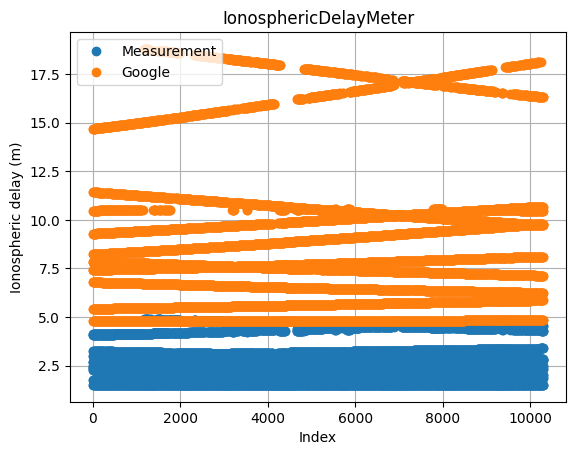

In [887]:
mea = pd.DataFrame()
t = pd.DataFrame()
mea['IonosphericDelayMeters1'] = measurement['IonosphericDelayMeters']

t['IonosphericDelayMeters'] = truth['IonosphericDelayMeters']
merged_df = pd.merge(mea, t,left_index=True, right_index=True)
merged_df = merged_df.dropna()
RMSE = np.sqrt(np.square(np.subtract(mea['IonosphericDelayMeters1'],t['IonosphericDelayMeters'])).mean())
print(RMSE)
# merged_df.to_csv('i# Plotting the vertical component of velocity and highlighting outliers
_measurement = mea['IonosphericDelayMeters1'].tolist()
_trust = t['IonosphericDelayMeters'].tolist()


plt.plot(_measurement, label='Measurement',marker='o', linestyle='none')
plt.plot(_trust,label = 'Google',marker='o', linestyle='none')
plt.title('IonosphericDelayMeter')

plt.legend()
plt.xlabel('Index')
plt.ylabel('Ionospheric delay (m)')
plt.grid(True)
